# Linear autoencoders

In this notebook we explore the use of linear autoencoders to compress data and synthesize new data.

A autoencoder, in its simplest form, is a neural network that is trained to match its output $z$ to its input $x$.  A linear autoencoder does not use any non-linear activation functions, so that the entire learned function is linear:

$$\mathbf{z} = \mathbf{W}_2(\mathbf{W}_1\mathbf{x}+\mathbf{b}_1)+\mathbf{b}_2$$

The autoencoder is composed of two parts: an encoder and a decoder.  We will denote the encoded version of the input as $\mathbf{h}$:

$$\mathbf{h} = \mathbf{W}_1\mathbf{x}+\mathbf{b}_1$$
$$\mathbf{z}= \mathbf{W}_2\mathbf{h}+\mathbf{b}_2$$

In the typical undercomplete autoencoder, $\mathbf{h}$ is smaller than $\mathbf{x}$ so we can think of the neural network as learning to compress and decompress the data.

Once we have trained the neural network, we can synthesize new data by randomly sampling $\mathbf{h}$ and decoding it.

In this notebook we train a linear autoencoder on the Frey dataset which contains about 2,000 faces of a single person's face with different poses and expressions.  Then we explore how well the autoencoder can compress and decompress data, synthesize new data, and interpolate between faces.

In [ ]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [ ]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))

np.random.seed(1234)
np.random.shuffle(images)

(1965, 28, 20)


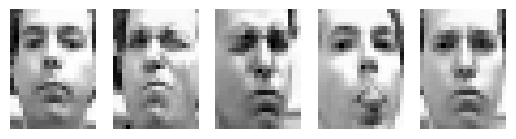

In [ ]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

We split the data into training and testing splits (the data was shuffled above) and then convert to floating point on [-1 1] range.

In [ ]:
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## Building the autoencoder model in Keras

To train the autoencoder, we will build a simple two-layer model in Keras: one layer for the encoder and one layer for the decoder.  At training time, we run data through the autoencoder and apply a reconstruction loss term such as mean squared error or mean absolute error.

However, at test time, we would like to be able to run the encoder or decoder separately.  For this reason, we make separate encoder and decoder models and then connect them in an autoencoder model.


In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

def build_encoder(latent_dim):
  inputs = Input((28,20),name='encoder_input')
  flat = Flatten()(inputs) # flatten to a vector
  embedding = Dense(latent_dim,activation=None,name='encoder')(flat)
  return Model(inputs=inputs,outputs=embedding)

def build_decoder(latent_dim):
  inputs = Input((latent_dim,),name='decoder_input')
  reconstruction = Dense(28*20,activation=None,name='decoder')(inputs)
  reshaped = Reshape((28,20))(reconstruction) # reshape back to an image
  return Model(inputs=inputs,outputs=reshaped)

def build_autoencoder(encoder,decoder):
  inputs = Input((28,20),name='autoencoder_input')
  embedding = encoder(inputs)
  reconstruction = decoder(embedding)
  return Model(inputs=inputs,outputs=reconstruction)

latent_dim = 32
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
autoencoder = build_autoencoder(encoder,decoder)

opt = Adam(3e-4)
autoencoder.compile(opt,loss='mean_squared_error')

In [ ]:
history = autoencoder.fit(x_train,x_train,batch_size=32,epochs=300,verbose=False,validation_split=0.1)

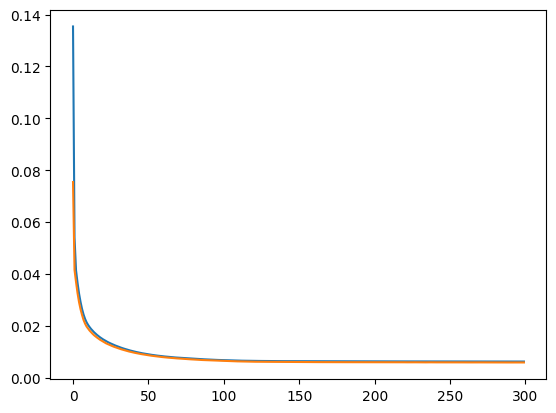

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Testing image reconstruction with the autoencoder

First we test the ability of the autoencoder to compress and then decompress data.  Note that the autoencoder compresses the input of size 560 down to a 32-dimensional vector and then decompresses it.  That is a 17.5x compression rate.

It can be seen that the reconstructed images look quite similar to the input, although some high-resolution detail is lost.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


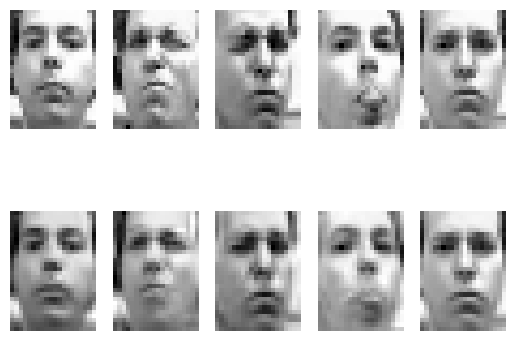

In [ ]:
result = autoencoder.predict(x_train)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i],cmap='gray')
  plt.axis('off')
  plt.subplot(2,5,5+i+1)
  plt.imshow(result[i],cmap='gray')
  plt.axis('off')
plt.show()

## Visualizing the embedding

By running the encoder without the decoder, we can visualize the embedding of the input images into 32-dimensional space.  Here we only visualize the first two dimensions of the embedding.

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


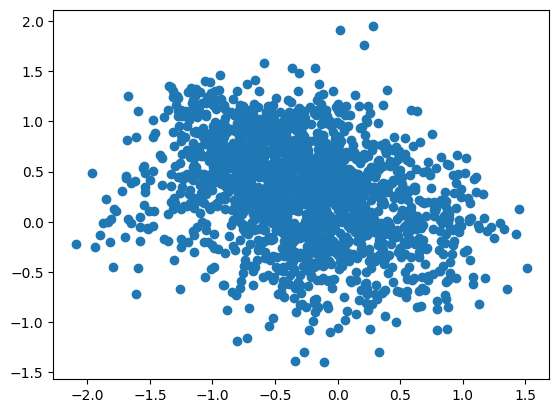

In [ ]:
encoder_result = encoder.predict(x_train)
plt.scatter(encoder_result[:,0],encoder_result[:,1])
plt.show()

## Randomly synthesizing new data

To randomly synthesize new data, we can attempt to select random embedding vectors which are similar to the embedding vectors of the training data.

To this, I chose to model the embedding with a multivariate Gaussian -- from the plot above, it is clear that this is only going to be an approximation.

In [ ]:
mu = np.mean(encoder_result,axis=0)
sigma = np.cov(encoder_result.T)

In [ ]:
random_embeddings = np.random.multivariate_normal(mu,sigma,size=(32))

By decoding the random embeddings, we can randomly generate new faces in the "face space" learned by the autoencoder.

Some images look plausible but many have artifacts.  Some faces look like a blend of many different faces which don't really cohere together.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


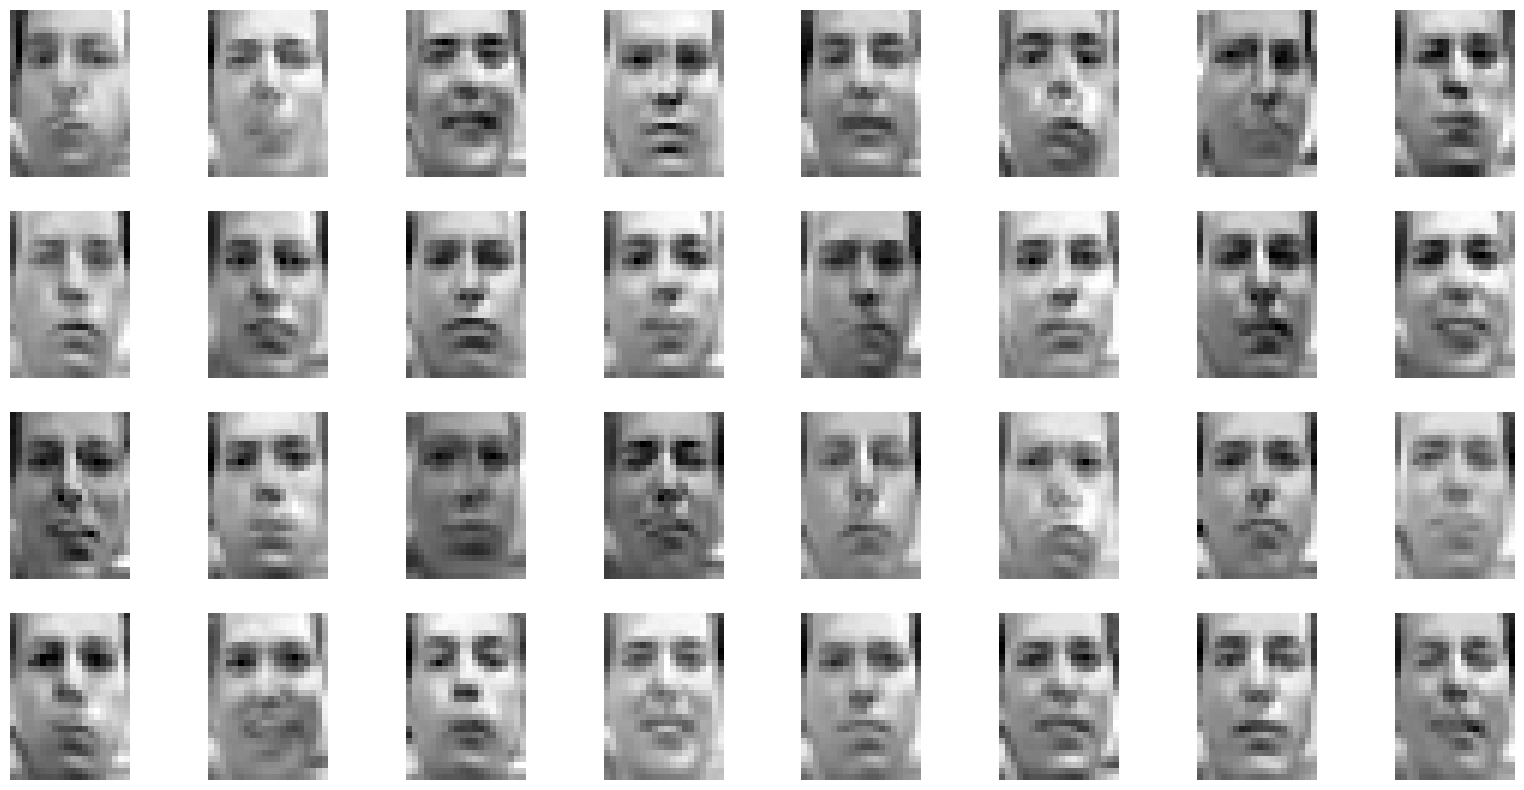

In [ ]:
plt.figure(figsize=(20,10))
decoder_result = decoder.predict(random_embeddings)
n = 0
for i in range(4):
  for j in range(8):
    plt.subplot(4,8,n+1)
    plt.imshow(decoder_result[n],cmap='gray')
    plt.axis('off')
    n = n + 1
plt.show()

## Inspecting the decoder weights

The decoder applies a linear transformation to the embedding to produce the output image:

$$\mathbf{z} = \mathbf{W}\mathbf{h}+\mathbf{b}$$

Let $h_1,\ldots,h_n$ be the coefficients of $\mathbf{h}$ and $\mathbf{w}_1,\ldots,\mathbf{w}_n$ be the columns of $\mathbf{W}$.

It can be easily seen that $\mathbf{z}$ is a linear combination of the columns of $\mathbf{W}$, where the coefficients in the linear combination come from $\mathbf{h}$:

$$\mathbf{z} = h_1\mathbf{w}_1 + \cdots + h_n\mathbf{w}_n + \mathbf{b}$$

By inspecting the weights in the decoder, we can see that each column vector of $\mathbf{W}$ looks like a different face; the decoder is blending these different faces together to produce the output.

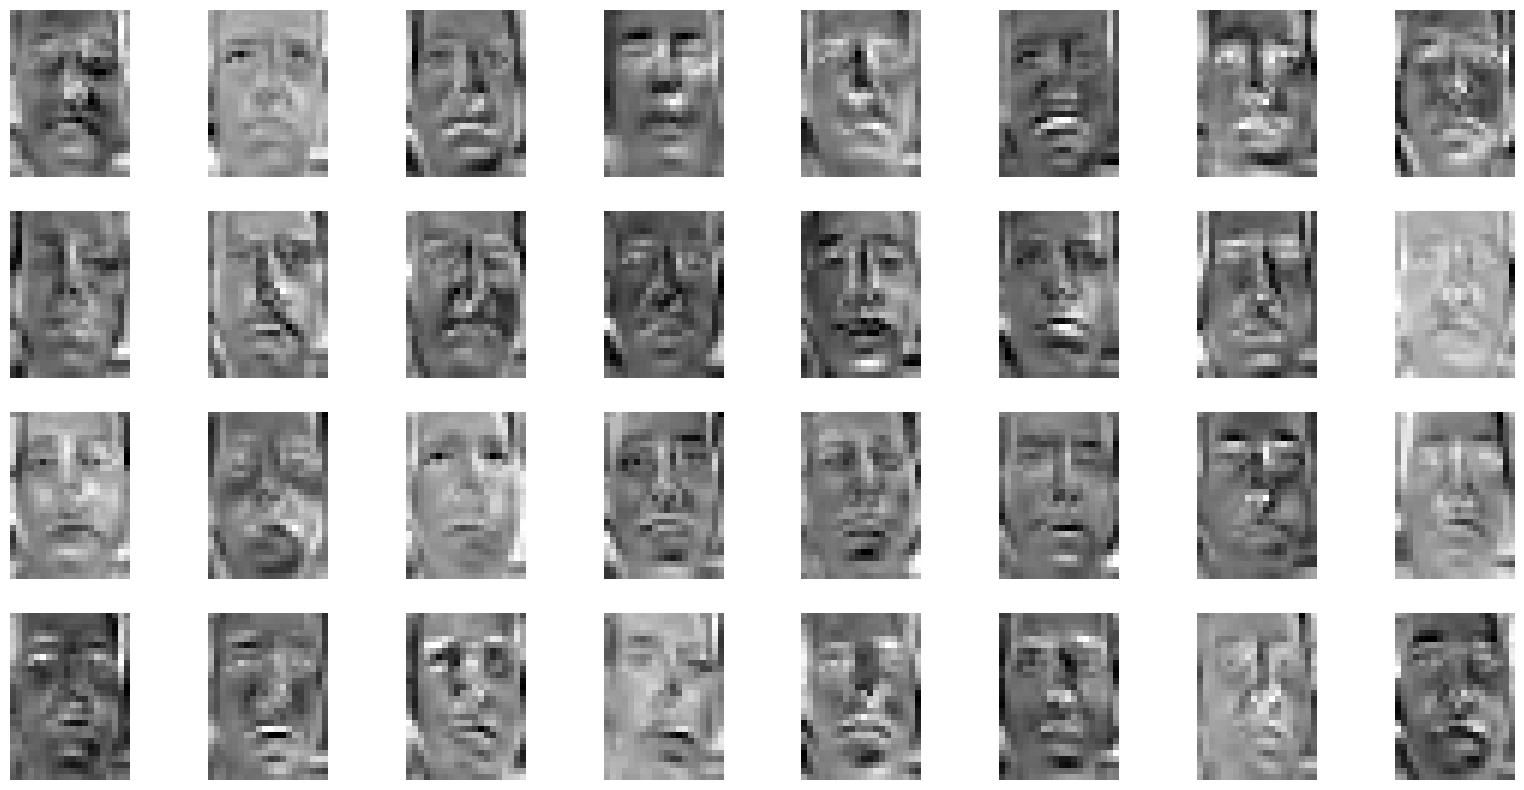

In [ ]:
plt.figure(figsize=(20,10))
weights = decoder.get_weights()[0]
n = 0
for i in range(4):
  for j in range(8):
    plt.subplot(4,8,n+1)
    plt.imshow(np.reshape(weights[n],(28,20)),cmap='gray')
    plt.axis('off')
    n = n + 1
plt.show()


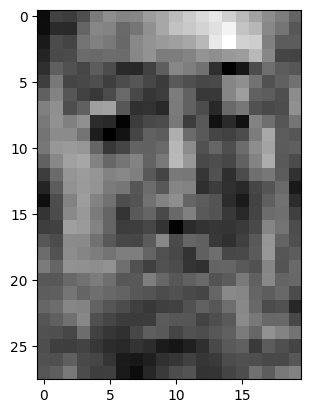

In [ ]:
bias = decoder.get_weights()[1]
bias = np.reshape(bias,(28,20))
plt.imshow(bias)
plt.show()

## Interpolating between faces

Now we see if we can interpolate between faces by stepping between their embedding vectors.

For two images $\mathbf{x}_1$ and $\mathbf{x}_2$, we first compute their encodings $\mathbf{h}_1$ and $\mathbf{h}_2$.  Then we synthesize images in-between by computing encodings between $\mathbf{h}_1$ and $\mathbf{h}_2$ and decoding them:

$$\mathbf{h} = (1-\alpha)\mathbf{h}_1 + \alpha\mathbf{h}_2$$



In [ ]:
def interpolate_between(imgA_index,imgB_index):
  plt.figure(figsize=(20,10))
  imgA = x_test[imgA_index]
  imgB = x_test[imgB_index]

  imgA_encoded = encoder.predict(x_test[imgA_index:(imgA_index+1)])
  imgB_encoded = encoder.predict(x_test[imgB_index:(imgB_index+1)])

  direction = imgB_encoded - imgA_encoded
  print(direction)

  alphas = np.linspace(0,1,num=10)
  for n,alpha in enumerate(alphas):
    alpha = alphas[n]
    img_encoded = (1-alpha)*imgA_encoded+alpha*imgB_encoded
    img = decoder.predict(img_encoded)
    plt.subplot(1,10,n+1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[ 0.6204698  -0.14535029 -1.8076402   0.73837245 -0.4566992   0.8217298
  -0.23618382  0.5351049   0.35523668 -0.4289934   0.6555856   0.6576309
   0.43937773 -0.4978971  -0.63171244  0.98648435  0.08321556 -1.3030885
  -0.09092307  0.8003862  -0.14021862 -0.10492015  1.0977354  -0.5317309
   0.3715865   0.9374286   0.04560754  0.12651527 -0.20674914  0.10488622
  -0.56114787 -0.9823147 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


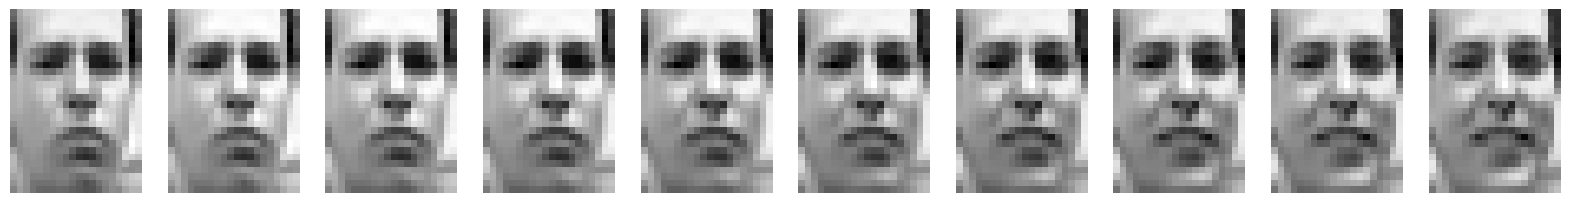

In [ ]:
interpolate_between(0,2)

The linear autoencoder in this case actually does a good job of interpolating between the two images!